In [1]:
# 在import tensorflow之前
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import morphology, filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm  # 导入tqdm库
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, \
    Flatten, Dropout, DepthwiseConv2D
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import sys

2024-11-14 09:42:06.375051: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 09:42:06.420617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 09:42:06.420657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 09:42:06.420683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 09:42:06.428929: I tensorflow/core/platform/cpu_feature_g

In [3]:
NUM = 14

In [4]:
# 定义数据集路径
data_folder = "./dataset/mymnist14"

x_data = []
y_data = []
x_data_original = []  # 用于存储原始图像


# 定义细化处理函数
def thin_image(image):
    binary_image = image > filters.threshold_otsu(image)
    skeleton = morphology.skeletonize(binary_image)
    thin_image = (skeleton * 255).astype(np.uint8)
    return thin_image


def resize_with_black_border(image, ratioX, ratioY):
    # 获取原始图像大小
    original_width, original_height = image.size

    # 根据比例计算缩放后的尺寸
    new_width = int(original_width * ratioX)
    new_height = int(original_height * ratioY)

    # 缩小图像
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # 创建一个黑色背景的新图像，大小与原图相同
    new_image = Image.new('L', (original_width, original_height), color=0)  # 'L' 模式为灰度图

    # 将缩小后的图像粘贴到黑色背景的中央
    left = (original_width - new_width) // 2
    top = (original_height - new_height) // 2
    new_image.paste(resized_image, (left, top))

    return new_image


# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []
    original_images = []

    # 使用tqdm显示进度条
    for img_name in tqdm(os.listdir(label_folder), desc=f'Loading images for label {label}'):
        img_path = os.path.join(label_folder, img_name)

        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小
        # if label == 0 or label == 10:
        #     image = resize_with_black_border(image, 0.7, 0.9)

        image_array = np.array(image)

        # 存储原始图像
        original_images.append(image_array)

        # 细化处理
        # image_array = thin_image(image_array)

        images.append(image_array)

    x_data.extend(images)
    y_data.extend([label] * len(images))
    x_data_original.extend(original_images)

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data_original = np.array(x_data_original)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# 创建一个ImageDataGenerator实例并设置增强参数
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=(0.7, 1.0),
    # width_shift_range=0.1,
    height_shift_range=0.05
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


Loading images for label 13: 100%|██████████| 110/110 [00:00<00:00, 6874.68it/s]


每种图片数量:
类别 0: 99 张
类别 1: 115 张
类别 2: 109 张
类别 3: 106 张
类别 4: 104 张
类别 5: 100 张
类别 6: 120 张
类别 7: 107 张
类别 8: 121 张
类别 9: 112 张
类别 10: 100 张
类别 11: 148 张
类别 12: 114 张
类别 13: 110 张


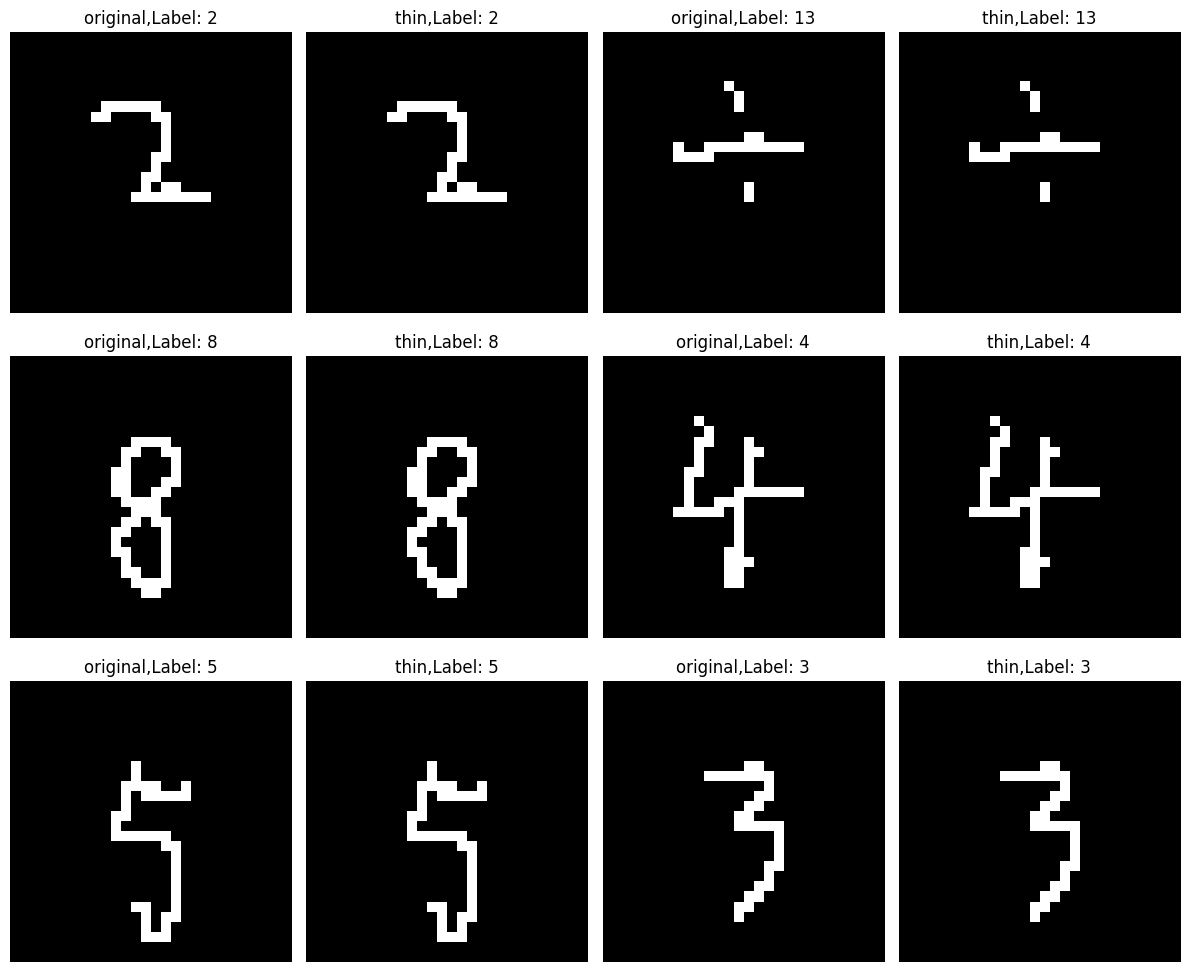

In [5]:
# 显示几个原始图像与细化后的对比图
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# 显示几个样本
for i in range(3):
    for j in range(2):
        idx = np.random.choice(len(x_data))  # 随机选择一个索引
        axes[i, j * 2].imshow(x_data_original[idx], cmap='gray')
        axes[i, j * 2].set_title(f"original,Label: {y_balanced[idx]}")
        axes[i, j * 2].axis('off')

        axes[i, j * 2 + 1].imshow(x_data[idx], cmap='gray')
        axes[i, j * 2 + 1].set_title(f"thin,Label: {y_balanced[idx]}")
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) / 255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) / 255

y_train = to_categorical(y_train, num_classes=NUM)
y_test = to_categorical(y_test, num_classes=NUM)

In [7]:
def init_model():
    model = Sequential()

    model.add(Conv2D(8, (5, 5), padding='same', strides=(2, 2), input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(16, (5, 5), padding='same', strides=(3, 3)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 

    model.add(Flatten())

    model.add(Dense(NUM))
    model.add(Dropout(0.3))
    model.add(Activation('softmax'))

    return model


model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 8)         208       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 8)         32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 14, 8)         0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          3216      
                                                                 
 batch_normalization_1 (Bat  (None, 5, 5, 16)          64        
 chNormalization)                                       

2024-11-14 09:42:09.759231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-14 09:42:09.759277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: VM-2-33-ubuntu
2024-11-14 09:42:09.759285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: VM-2-33-ubuntu
2024-11-14 09:42:09.759436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2024-11-14 09:42:09.759458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2024-11-14 09:42:09.759464: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17


In [8]:
# 编译模型
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])
model.load_weights('best_model.h5')

In [9]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


10/10 [==============================] - 1s 3ms/step - loss: 0.7546 - categorical_accuracy: 0.7220

测试集的总体准确率: 0.72
10/10 [==============================] - 0s 2ms/step

每种类别的错误率:
类别 0: 0.32
类别 1: 0.00
类别 2: 0.13
类别 3: 0.08
类别 4: 0.24
类别 5: 0.74
类别 6: 0.11
类别 7: 0.39
类别 8: 0.19
类别 9: 0.37
类别 10: 0.24
类别 11: 0.11
类别 12: 0.62
类别 13: 0.54


In [14]:
for layer in model.layers[:7]:  # 这里的 7 指的是冻结前四层
    layer.trainable = False

In [15]:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 8)         208       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 8)         32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 14, 8)         0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          3216      
                                                                 
 batch_normalization_1 (Bat  (None, 5, 5, 16)          64        
 chNormalization)                                       

In [16]:
# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model_fine_tuning.h5', monitor='val_loss', save_best_only=True, mode='min')

history = None
# windows 开多线程后会卡死，不知道为什么，垃圾系统
if sys.platform.startswith('win'):
    history = model.fit(x_train,y_train,
                        batch_size=128,
                        epochs=30,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True)
else:
    history = model.fit(x_train,y_train,
                        batch_size=128,
                        epochs=30,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True,
                        max_queue_size=100,
                        workers = 8,
                        use_multiprocessing=True)

# 加载最佳模型权重
model.load_weights('best_model_fine_tuning.h5')

Epoch 1/30
10/10 - 1s - loss: 1.2373 - categorical_accuracy: 0.6102 - val_loss: 0.4616 - val_categorical_accuracy: 0.8403 - 1s/epoch - 105ms/step
Epoch 2/30
10/10 - 0s - loss: 0.9231 - categorical_accuracy: 0.6645 - val_loss: 0.3146 - val_categorical_accuracy: 0.9010 - 108ms/epoch - 11ms/step
Epoch 3/30


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 - 0s - loss: 0.8705 - categorical_accuracy: 0.6829 - val_loss: 0.2220 - val_categorical_accuracy: 0.9297 - 107ms/epoch - 11ms/step
Epoch 4/30
10/10 - 0s - loss: 0.8062 - categorical_accuracy: 0.7005 - val_loss: 0.1937 - val_categorical_accuracy: 0.9361 - 108ms/epoch - 11ms/step
Epoch 5/30
10/10 - 0s - loss: 0.7545 - categorical_accuracy: 0.7204 - val_loss: 0.1601 - val_categorical_accuracy: 0.9553 - 109ms/epoch - 11ms/step
Epoch 6/30
10/10 - 0s - loss: 0.7011 - categorical_accuracy: 0.7300 - val_loss: 0.1288 - val_categorical_accuracy: 0.9649 - 107ms/epoch - 11ms/step
Epoch 7/30
10/10 - 0s - loss: 0.6596 - categorical_accuracy: 0.7396 - val_loss: 0.1150 - val_categorical_accuracy: 0.9776 - 107ms/epoch - 11ms/step
Epoch 8/30
10/10 - 0s - loss: 0.6999 - categorical_accuracy: 0.7125 - val_loss: 0.1071 - val_categorical_accuracy: 0.9776 - 108ms/epoch - 11ms/step
Epoch 9/30
10/10 - 0s - loss: 0.6890 - categorical_accuracy: 0.7149 - val_loss: 0.0911 - val_categorical_accuracy: 0.9808 -

10/10 [==============================] - 0s 2ms/step - loss: 0.0344 - categorical_accuracy: 0.9936

测试集的总体准确率: 0.99
10/10 [==============================] - 0s 2ms/step


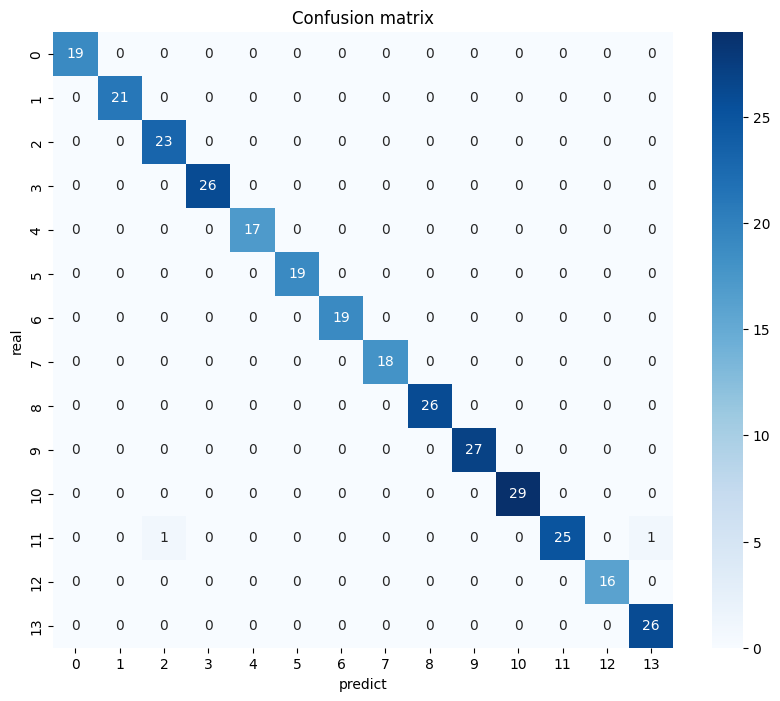

In [18]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM), yticklabels=range(NUM))
plt.xlabel('predict')
plt.ylabel('real')
plt.title('Confusion matrix')
plt.show()


In [17]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


10/10 [==============================] - 0s 2ms/step - loss: 0.0344 - categorical_accuracy: 0.9936

测试集的总体准确率: 0.99
10/10 [==============================] - 0s 2ms/step

每种类别的错误率:
类别 0: 0.00
类别 1: 0.00
类别 2: 0.00
类别 3: 0.00
类别 4: 0.00
类别 5: 0.00
类别 6: 0.00
类别 7: 0.00
类别 8: 0.00
类别 9: 0.00
类别 10: 0.00
类别 11: 0.07
类别 12: 0.00
类别 13: 0.00


In [19]:
# 导出模型
model.export("mnist_fine_tuning")
# 调用转换脚本
!python tools/h5_to_tflite.py mnist_fine_tuning mnist_fine_tuning.tflite 1 dataset/mymnist14  0to1
!python tools/tflite2tmdl.py mnist_fine_tuning.tflite mnist_fine_tuning.tmdl int8 1 28,28,1 {NUM} 1

INFO:tensorflow:Assets written to: mnist_fine_tuning/assets


INFO:tensorflow:Assets written to: mnist_fine_tuning/assets


Saved artifact at 'mnist_fine_tuning'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    float32 Tensor, shape=(None, 14)
2024-11-14 09:51:13.272962: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 09:51:13.316285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 09:51:13.316342: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 09:51:13.316376: E tensorflow/compiler/xla/stream_executor/cuda/cu